In [1]:
import pandas as pd
import sklearn
import numpy as np
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch
from datasets import load_dataset
import tensorflow as tf
import tensorflow_addons as tfa
import keras

from keras import optimizers
import matplotlib.pyplot as plt
from keras import initializers
from keras.utils import np_utils
from keras import regularizers
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.layers import concatenate
from keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization, ReLU
from keras.layers import LSTM, Bidirectional
import pickle
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_goss_train_xlnet = pd.read_pickle('../../Dissertation - Fake News/Embeddings/df_train_xlnet_simple.pkl')
df_goss_val_xlnet = pd.read_pickle('../../Dissertation - Fake News/Embeddings/df_val_xlnet_simple.pkl')
df_goss_test_xlnet = pd.read_pickle('../../Dissertation - Fake News/Embeddings/df_test_xlnet_simple.pkl')

In [3]:
def label_change(df):
    if df['label'] == 0: return 1
    else: return 0

In [4]:
df_goss_train_xlnet['target'] = df_goss_train_xlnet.apply(label_change, axis=1)
df_goss_train_xlnet.head()

,hidden_state,label,idx,target
0,"[[-0.6905054, 0.10080558, -3.5896642, 0.688696...",0,1934,1
1,"[[0.71386486, 1.624135, 0.39983767, 1.6060241,...",0,1408,1
2,"[[-1.4997008, -2.5545237, -2.6850965, 2.128371...",0,2589,1
3,"[[-0.59582114, 0.6739678, -0.54739684, 0.43669...",1,5778,0
4,"[[-0.17796452, 1.5538232, -0.1271606, 0.483559...",0,2922,1


In [5]:
df_goss_val_xlnet['target'] = df_goss_val_xlnet.apply(label_change, axis=1)
df_goss_test_xlnet['target'] = df_goss_test_xlnet.apply(label_change, axis=1)

In [6]:
# Count samples per class: 0-real, 1-fake
classes_zero = df_goss_train_xlnet[df_goss_train_xlnet['target'] == 0]
classes_one = df_goss_train_xlnet[df_goss_train_xlnet['target'] == 1]

# Convert parts into NumPy arrays for weight computation
zero_numpy = classes_zero['target'].to_numpy()
one_numpy = classes_one['target'].to_numpy()
all_together = np.concatenate((zero_numpy, one_numpy))
unique_classes = np.unique(all_together)

# Compute weights
weights = sklearn.utils.class_weight.compute_class_weight('balanced', unique_classes, all_together)
print(weights)

[0.64400494 2.2360515 ]


C:\Users\labca\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [7]:
weights_ker = {i : weights[i] for i in range(2)}
weights_ker

{0: 0.6440049443757726, 1: 2.236051502145923}

In [8]:
df_goss_train_xcep = pd.read_pickle('../../Dissertation - Fake News/Embeddings/df_train_xception_block12_tuned.pkl')
df_goss_val_xcep = pd.read_pickle('../../Dissertation - Fake News/Embeddings/df_val_xception_block12_tuned.pkl')
df_goss_test_xcep = pd.read_pickle('../../Dissertation - Fake News/Embeddings/df_test_xception_block12_tuned.pkl')

In [9]:
df_goss_train_xlnet.head()

,hidden_state,label,idx,target
0,"[[-0.6905054, 0.10080558, -3.5896642, 0.688696...",0,1934,1
1,"[[0.71386486, 1.624135, 0.39983767, 1.6060241,...",0,1408,1
2,"[[-1.4997008, -2.5545237, -2.6850965, 2.128371...",0,2589,1
3,"[[-0.59582114, 0.6739678, -0.54739684, 0.43669...",1,5778,0
4,"[[-0.17796452, 1.5538232, -0.1271606, 0.483559...",0,2922,1


In [10]:
df_goss_train_xcep.head()

,img_features,label,idx
1902,"[[0.12345049, 0.103692524, 0.10679071, 0.11953...",0,1934
1386,"[[0.025142414, 0.11223217, 0.02097135, 6.14750...",0,1408
2539,"[[0.027030187, 0.10288904, 0.30019975, 0.05462...",0,2589
5649,"[[0.37826172, 0.4675789, 0.15682955, 0.2555534...",1,5778
2869,"[[0.0014517182, 0.034252882, 0.012506969, 0.04...",0,2922


In [11]:
df_train_merge = df_goss_train_xlnet.merge(df_goss_train_xcep, left_on=["label","idx"], right_on=["label","idx"], how = 'left')
df_train_merge.head()

,hidden_state,label,idx,target,img_features
0,"[[-0.6905054, 0.10080558, -3.5896642, 0.688696...",0,1934,1,"[[0.12345049, 0.103692524, 0.10679071, 0.11953..."
1,"[[0.71386486, 1.624135, 0.39983767, 1.6060241,...",0,1408,1,"[[0.025142414, 0.11223217, 0.02097135, 6.14750..."
2,"[[-1.4997008, -2.5545237, -2.6850965, 2.128371...",0,2589,1,"[[0.027030187, 0.10288904, 0.30019975, 0.05462..."
3,"[[-0.59582114, 0.6739678, -0.54739684, 0.43669...",1,5778,0,"[[0.37826172, 0.4675789, 0.15682955, 0.2555534..."
4,"[[-0.17796452, 1.5538232, -0.1271606, 0.483559...",0,2922,1,"[[0.0014517182, 0.034252882, 0.012506969, 0.04..."


In [12]:
df_train_merge.drop(columns=['label'])

,hidden_state,idx,target,img_features
0,"[[-0.6905054, 0.10080558, -3.5896642, 0.688696...",1934,1,"[[0.12345049, 0.103692524, 0.10679071, 0.11953..."
1,"[[0.71386486, 1.624135, 0.39983767, 1.6060241,...",1408,1,"[[0.025142414, 0.11223217, 0.02097135, 6.14750..."
2,"[[-1.4997008, -2.5545237, -2.6850965, 2.128371...",2589,1,"[[0.027030187, 0.10288904, 0.30019975, 0.05462..."
3,"[[-0.59582114, 0.6739678, -0.54739684, 0.43669...",5778,0,"[[0.37826172, 0.4675789, 0.15682955, 0.2555534..."
4,"[[-0.17796452, 1.5538232, -0.1271606, 0.483559...",2922,1,"[[0.0014517182, 0.034252882, 0.012506969, 0.04..."
...,...,...,...,...
10415,"[[-0.7371248, 0.6129089, -3.298514, 1.209125, ...",286,1,"[[0.16177247, 0.3310165, 0.59982514, 0.2488132..."
10416,"[[1.0488812, -1.935956, -1.8871863, -0.7197717...",8822,0,"[[0.29817665, 0.32366443, 0.19224147, 0.146774..."
10417,"[[-1.5430726, 0.7797304, 0.09906371, -2.101035...",376,1,"[[0.24539898, 0.02857017, 0.0927768, 0.0, 0.16..."
10418,"[[0.8006587, -1.8282557, -1.5217248, 0.6617957...",2667,1,"[[0.009503191, 0.020403562, 0.070773065, 0.001..."


In [13]:
df_train_merge.isnull().values.any()

False

In [14]:
df_val_merge = df_goss_val_xlnet.merge(df_goss_val_xcep, left_on=["label","idx"], right_on=["label","idx"], how = 'left')
df_val_merge.drop(columns=['label'])
df_val_merge.isnull().values.any()

False

In [15]:
df_test_merge = df_goss_test_xlnet.merge(df_goss_test_xcep, left_on=["label","idx"], right_on=["label","idx"], how = 'left')
df_test_merge.drop(columns=['label'])
df_test_merge.isnull().values.any()

False

In [16]:
df_train_merge.dtypes

hidden_state    object
label            int64
idx              int64
target           int64
img_features    object
dtype: object

In [17]:
array_train = df_train_merge[["hidden_state", "img_features","target"]].to_numpy() 
X_train_txt = np.array(array_train[:,0].tolist())
X_train_txt = np.squeeze(X_train_txt, 1)
X_train_txt.shape

(10420, 768)

In [18]:
X_train_txt = torch.from_numpy(X_train_txt)
X_train_img = np.array(array_train[:,1].tolist())
X_train_img = np.squeeze(X_train_img, 1)
X_train_img = torch.from_numpy(X_train_img)

X_train_label = np.array(array_train[:,2].tolist())
X_train_label = np.asarray(X_train_label).astype('float32')
X_train_label = torch.from_numpy(X_train_label)

train_dataset1 = tf.data.Dataset.from_tensor_slices(X_train_txt)
train_dataset2 = tf.data.Dataset.from_tensor_slices((X_train_img))
train_dataset3 = tf.data.Dataset.from_tensor_slices((X_train_label))
train_dataset_all = tf.data.Dataset.zip((train_dataset1, train_dataset2))
train_dataset_all = tf.data.Dataset.zip((train_dataset_all, train_dataset3))

train_text_only = tf.data.Dataset.zip((train_dataset1, train_dataset3))
train_image_only = tf.data.Dataset.zip((train_dataset2, train_dataset3))

In [19]:
train_dataset_all.element_spec

((TensorSpec(shape=(768,), dtype=tf.float32, name=None),
  TensorSpec(shape=(2048,), dtype=tf.float32, name=None)),
 TensorSpec(shape=(), dtype=tf.float32, name=None))

In [20]:
train_dataset_all = train_dataset_all.batch(32)
train_text_only = train_text_only.batch(32)
train_image_only = train_image_only.batch(32)

In [21]:
array_val = df_val_merge[["hidden_state", "img_features","target"]].to_numpy() 
X_val_txt = np.array(array_val[:,0].tolist())
X_val_txt = np.squeeze(X_val_txt, 1)

In [22]:
X_val_txt = torch.from_numpy(X_val_txt)
X_val_img = np.array(array_val[:,1].tolist())
X_val_img = np.squeeze(X_val_img, 1)
X_val_img = torch.from_numpy(X_val_img)

X_val_label = np.array(array_val[:,2].tolist())
X_val_label = np.asarray(X_val_label).astype('float32')
X_val_label = torch.from_numpy(X_val_label)

val_dataset1 = tf.data.Dataset.from_tensor_slices(X_val_txt)
val_dataset2 = tf.data.Dataset.from_tensor_slices((X_val_img))
val_dataset3 = tf.data.Dataset.from_tensor_slices((X_val_label))
val_dataset_all = tf.data.Dataset.zip((val_dataset1, val_dataset2))
val_dataset_all = tf.data.Dataset.zip((val_dataset_all, val_dataset3))

val_text_only = tf.data.Dataset.zip((val_dataset1, val_dataset3))
val_image_only = tf.data.Dataset.zip((val_dataset2, val_dataset3))

In [23]:
val_dataset_all = val_dataset_all.batch(32)
val_text_only = val_text_only.batch(32)
val_image_only = val_image_only.batch(32)

In [24]:
array_test = df_test_merge[["hidden_state", "img_features","target"]].to_numpy()
X_test_txt = np.array(array_test[:,0].tolist())
X_test_txt = np.squeeze(X_test_txt, 1)
X_test_txt = torch.from_numpy(X_test_txt)
X_test_img = np.array(array_test[:,1].tolist())
X_test_img = np.squeeze(X_test_img, 1)
X_test_img = torch.from_numpy(X_test_img)

X_test_label = np.array(array_test[:,2].tolist())
X_test_label = np.asarray(X_test_label).astype('float32')
X_test_label = torch.from_numpy(X_test_label)

test_dataset1 = tf.data.Dataset.from_tensor_slices(X_test_txt)
test_dataset2 = tf.data.Dataset.from_tensor_slices((X_test_img))
test_dataset3 = tf.data.Dataset.from_tensor_slices((X_test_label))
test_dataset_all = tf.data.Dataset.zip((test_dataset1, test_dataset2))
test_dataset_all = tf.data.Dataset.zip((test_dataset_all, test_dataset3))

test_text_only = tf.data.Dataset.zip((test_dataset1, test_dataset3))
test_image_only = tf.data.Dataset.zip((test_dataset2, test_dataset3))

In [25]:
X_test_txt1 = np.array(array_test[:,0].tolist())
X_test_txt1 = np.squeeze(X_test_txt, 1)
X_test_img1 = np.array(array_test[:,1].tolist())
X_test_img1 = np.squeeze(X_test_img, 1)

In [26]:
test_dataset_input = tf.data.Dataset.zip((test_dataset1, test_dataset2))
test_dataset_input = test_dataset_input.batch(32)

In [27]:
test_dataset_all = test_dataset_all.batch(32)
test_text_only = test_text_only.batch(32)
test_image_only = test_image_only.batch(32)

In [28]:
macro_f1 =tfa.metrics.F1Score(num_classes=2, average='macro')
adam = optimizers.Adam(learning_rate=1e-5)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [29]:
def reset_tensorflow_keras_backend():
    keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    _ = gc.collect()

In [30]:
input_text = Input(shape=(768))
dense_text = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01),\
                kernel_initializer=initializers.he_normal(seed=0))(input_text)
dropout = Dropout(0.4)(dense_text)
dense_text = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01),\
                kernel_initializer=initializers.he_normal(seed=0))(dropout)
dense_text = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01),\
                kernel_initializer=initializers.he_normal(seed=0))(dense_text)

input_image = Input(shape=(2048))
img_dense = Dense(1024,activation='relu',kernel_regularizer=regularizers.l2(0.05),\
                kernel_initializer=initializers.he_normal(seed=0))(input_image)
dropout_img = Dropout(0.4)(img_dense)
img_dense = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.01),\
                kernel_initializer=initializers.he_normal(seed=0))(dropout_img)
img_dense = Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.01),\
                kernel_initializer=initializers.he_normal(seed=0))(img_dense)

concat = concatenate([dense_text,img_dense])

inter1_dense = Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.001), kernel_initializer=initializers.he_normal(seed=0))(concat)
final_dense = Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.001), kernel_initializer=initializers.he_normal(seed=0))(inter1_dense)
final_dropout = Dropout(0.4)(final_dense)

output = Dense(1, activation='sigmoid')(final_dropout)

In [31]:
model = Model(inputs=[input_text,input_image], outputs=output)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', tf.keras.metrics.TruePositives(),\
                                                                  tf.keras.metrics.TrueNegatives(),\
                                                                  tf.keras.metrics.FalsePositives(),\
                                                                  tf.keras.metrics.FalseNegatives()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 1024)         787456      ['input_1[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 1024)         2098176     ['input_2[0][0]']                
                                                                                              

In [32]:
history_combined = model.fit(train_dataset_all,
                    validation_data=(val_dataset_all), batch_size=32,epochs=100,
                            callbacks=[callback], verbose=1, class_weight= weights_ker, shuffle=True)

Epoch 1/100
326/326 [==============================] - 6s 13ms/step - loss: 142.1610 - accuracy: 0.5086 - true_positives: 1164.0000 - true_negatives: 4136.0000 - false_positives: 3954.0000 - false_negatives: 1166.0000 - val_loss: 132.4887 - val_accuracy: 0.5756 - val_true_positives: 188.0000 - val_true_negatives: 562.0000 - val_false_positives: 449.0000 - val_false_negatives: 104.0000
Epoch 2/100
326/326 [==============================] - 4s 12ms/step - loss: 125.1370 - accuracy: 0.5371 - true_positives: 1267.0000 - true_negatives: 4330.0000 - false_positives: 3760.0000 - false_negatives: 1063.0000 - val_loss: 117.0533 - val_accuracy: 0.6163 - val_true_positives: 166.0000 - val_true_negatives: 637.0000 - val_false_positives: 374.0000 - val_false_negatives: 126.0000
Epoch 3/100
326/326 [==============================] - 4s 12ms/step - loss: 110.4858 - accuracy: 0.5521 - true_positives: 1244.0000 - true_negatives: 4509.0000 - false_positives: 3581.0000 - false_negatives: 1086.0000 - val_

326/326 [==============================] - 4s 12ms/step - loss: 4.8645 - accuracy: 0.7777 - true_positives: 1790.0000 - true_negatives: 6314.0000 - false_positives: 1776.0000 - false_negatives: 540.0000 - val_loss: 4.8350 - val_accuracy: 0.7444 - val_true_positives: 174.0000 - val_true_negatives: 796.0000 - val_false_positives: 215.0000 - val_false_negatives: 118.0000
Epoch 44/100
326/326 [==============================] - 4s 12ms/step - loss: 4.6911 - accuracy: 0.7774 - true_positives: 1788.0000 - true_negatives: 6313.0000 - false_positives: 1777.0000 - false_negatives: 542.0000 - val_loss: 4.6734 - val_accuracy: 0.7368 - val_true_positives: 173.0000 - val_true_negatives: 787.0000 - val_false_positives: 224.0000 - val_false_negatives: 119.0000
Epoch 45/100
326/326 [==============================] - 4s 12ms/step - loss: 4.5288 - accuracy: 0.7762 - true_positives: 1803.0000 - true_negatives: 6285.0000 - false_positives: 1805.0000 - false_negatives: 527.0000 - val_loss: 4.5090 - val_accu

326/326 [==============================] - 4s 12ms/step - loss: 1.8753 - accuracy: 0.8275 - true_positives: 1967.0000 - true_negatives: 6656.0000 - false_positives: 1434.0000 - false_negatives: 363.0000 - val_loss: 2.0194 - val_accuracy: 0.7521 - val_true_positives: 182.0000 - val_true_negatives: 798.0000 - val_false_positives: 213.0000 - val_false_negatives: 110.0000
Epoch 86/100
326/326 [==============================] - 4s 12ms/step - loss: 1.8482 - accuracy: 0.8275 - true_positives: 1950.0000 - true_negatives: 6673.0000 - false_positives: 1417.0000 - false_negatives: 380.0000 - val_loss: 1.9742 - val_accuracy: 0.7590 - val_true_positives: 173.0000 - val_true_negatives: 816.0000 - val_false_positives: 195.0000 - val_false_negatives: 119.0000
Epoch 87/100
326/326 [==============================] - 4s 12ms/step - loss: 1.8210 - accuracy: 0.8263 - true_positives: 1961.0000 - true_negatives: 6649.0000 - false_positives: 1441.0000 - false_negatives: 369.0000 - val_loss: 1.9840 - val_accu

In [33]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [34]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

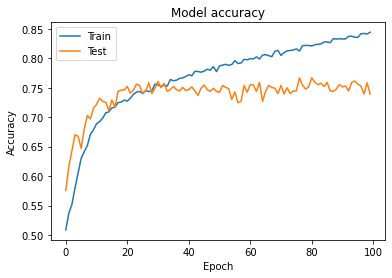

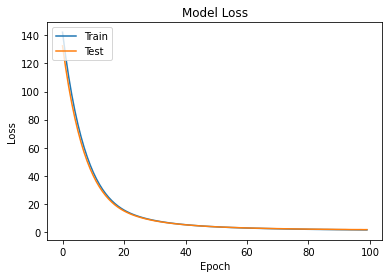

In [35]:
model_comb_plotacc = plot_accuracy(history_combined)
model_comb_plotloss = plot_loss(history_combined)

In [36]:
results = model.evaluate(test_dataset_all, batch_size=32)
print(results)

41/41 [==============================] - 0s 7ms/step - loss: 1.7313 - accuracy: 0.7467 - true_positives: 194.0000 - true_negatives: 779.0000 - false_positives: 240.0000 - false_negatives: 90.0000
[1.7313390970230103, 0.7467383146286011, 194.0, 779.0, 240.0, 90.0]


In [44]:
cm_list = [[194, 240], [90, 779]]

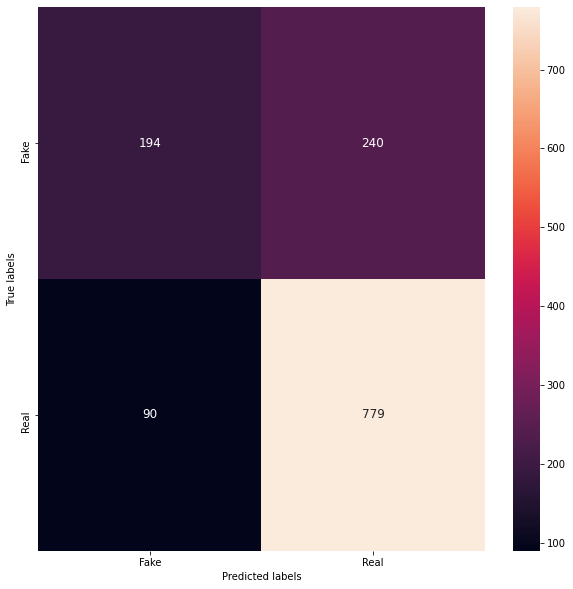

In [55]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(cm_list, range(2),range(2))
plt.figure(figsize = (10,10))

s = sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='g',
           xticklabels=['Fake','Real'], yticklabels=['Fake', 'Real'])
s.set(xlabel='Predicted labels', ylabel = 'True labels')
plt.show()

In [59]:
precision_fake = 194/(194+240)
recall_fake = 194/(194+90)
f1_fake = (2*precision_fake*recall_fake)/(precision_fake+recall_fake)
print(precision_fake, recall_fake, f1_fake)

0.4470046082949309 0.6830985915492958 0.5403899721448467


In [62]:
precision_real = 779/(779+90)
recall_real = 779/(779+240)
f1_real = (2*precision_real*recall_real)/(precision_real+recall_real)
print(precision_real, recall_real, f1_real)

0.8964326812428078 0.7644749754661433 0.8252118644067797


In [66]:
print(np.mean([f1_fake,f1_real]))

0.6828009182758132
